In [1]:
import os

import numpy as np
from scipy.stats import sem
import importlib
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
from models import SR_IS_NHB
from utils import policy_reval, woodbury
from utils_render import plot_nhb_decisions, create_bar_plot, plot_decision_prob

In [2]:
# Save dir
save_dir = os.path.join('..', 'figures/')

In [3]:
# For plotting
prob_locs = [1, 2]
colors = [3, 2]

In [4]:
## Hyperparameters for "Normal" model
lambd = 10
alpha = 0.15
beta = 1.0
num_steps = 2500
num_iterations = 800

In [5]:
def softmax(logits, temp=1.0):
    """softmax function for action selection"""
    exp_logits = np.exp(logits / temp - np.max(logits / temp))
    return exp_logits / np.sum(exp_logits)

# Policy Revaluation

In [6]:
probs_policy_train = []
probs_policy_test = []

for i in range(num_iterations):
    np.random.seed(i)

    agent = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="policy_reval")
    agent.learn(seed=i)

    # Train policy
    probs = softmax(logits=np.array([agent.V[1], agent.V[2]]), temp=1.0)
    probs_policy_train.append(probs)

    # Policy revaluation
    agent.update_exp()
    V_new, Z_new = policy_reval(agent)

    # Test policy
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0)
    # dec_test = np.random.choice(len(probs), p=probs)   # Softmax action selection
    probs_policy_test.append(probs)

## Action Selection Probs

In [7]:
# Train
probs_policy_train = np.array(probs_policy_train)
mean_policy_train = np.mean(probs_policy_train, axis=0)
sem_policy_train = sem(probs_policy_train, axis=0)

# Test
probs_policy_test = np.array(probs_policy_test)
mean_policy_test = np.mean(probs_policy_test, axis=0)
sem_policy_test = sem(probs_policy_test, axis=0)

# Reward Revaluation

### TD Models

In [8]:
probs_reward_train = []
probs_reward_test = []

for i in range(num_iterations):
    np.random.seed(i)
    # Define agents
    agent = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="reward_reval")
    agent.learn(seed=i)

    # Train policy
    probs = softmax(logits=np.array([agent.V[1], agent.V[2]]), temp=1.0)
    probs_reward_train.append(probs)

    # Policy revaluation
    agent.update_exp()
    V_new, Z_new = policy_reval(agent)
    
    # Test policy
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0)
    probs_reward_test.append(probs)

## Action Selection Probs

In [9]:
# Train
probs_reward_train = np.array(probs_reward_train)
mean_reward_train = np.mean(probs_reward_train, axis=0)
sem_reward_train = sem(probs_reward_train, axis=0)

# Test
probs_reward_test = np.array(probs_reward_test)
mean_reward_test = np.mean(probs_reward_test, axis=0)
sem_reward_test = sem(probs_reward_test, axis=0)

# Transition Revaluation

In [10]:
probs_transition_train = []
probs_transition_test = []

for i in range(num_iterations):
    np.random.seed(i)

    agent = SR_IS_NHB(_lambda=lambd, alpha=alpha, beta=beta, num_steps=num_steps, policy="softmax", imp_samp=True, exp_type="trans_reval")
    agent.learn(seed=i)

    # Train policy
    probs = softmax(logits=np.array([agent.V[1], agent.V[2]]), temp=1.0)
    probs_transition_train.append(probs)

    # Transition revaluation
    T_new = agent.construct_T_new()
    D_new = woodbury(agent=agent, T=T_new, inv=False)
    D_new += np.abs(np.min(D_new)) + 0.01
    agent.DR = D_new
    agent.update_Z()
    agent.update_V()
    V_new = agent.V

    # Softmax decision at test
    probs = softmax(logits=np.array([V_new[1], V_new[2]]), temp=1.0)
    probs_transition_test.append(probs)

## Action Selection Probs

In [11]:
# Train
probs_transition_train = np.array(probs_transition_train)
mean_transition_train = np.mean(probs_transition_train, axis=0)
sem_transition_train = sem(probs_transition_train, axis=0)

# Test
probs_transition_test = np.array(probs_transition_test)
mean_transition_test = np.mean(probs_transition_test, axis=0)
sem_transition_test = sem(probs_transition_test, axis=0)

# Plot Simulation Results

## Train

In [12]:
sem_reward_train

array([3.63311021e-17, 2.78865757e-16])

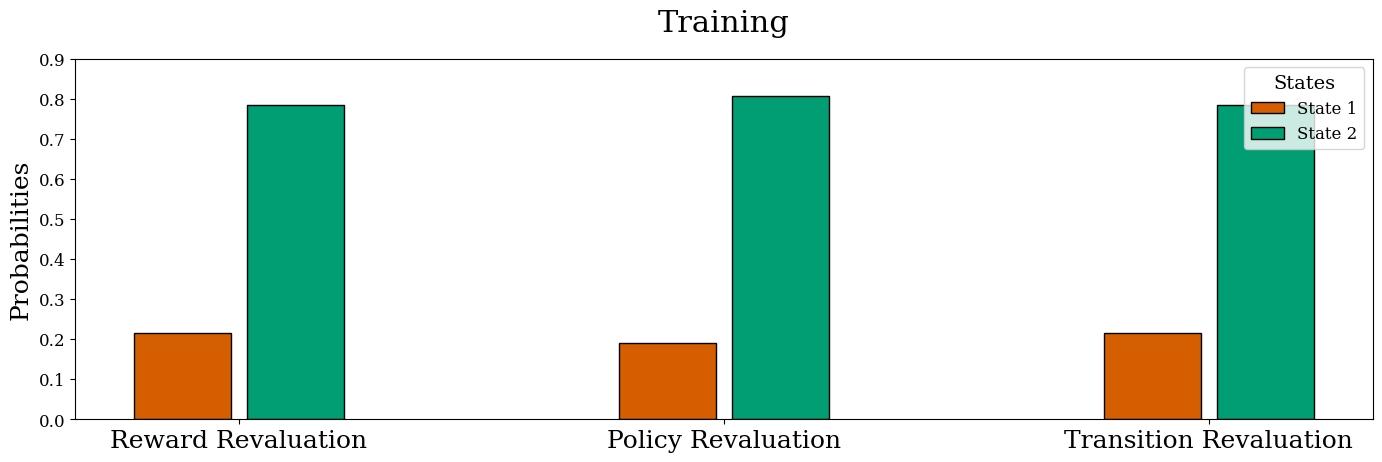

In [17]:
save_path = save_dir + "nhb_simulations_train.png"
# save_path = None

plot_nhb_decisions(
    probs_reward=mean_reward_train,
    probs_policy=mean_policy_train,
    probs_transition=mean_transition_train,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='Training',
    std=[sem_reward_train, sem_policy_train, sem_transition_train]
)

## Test

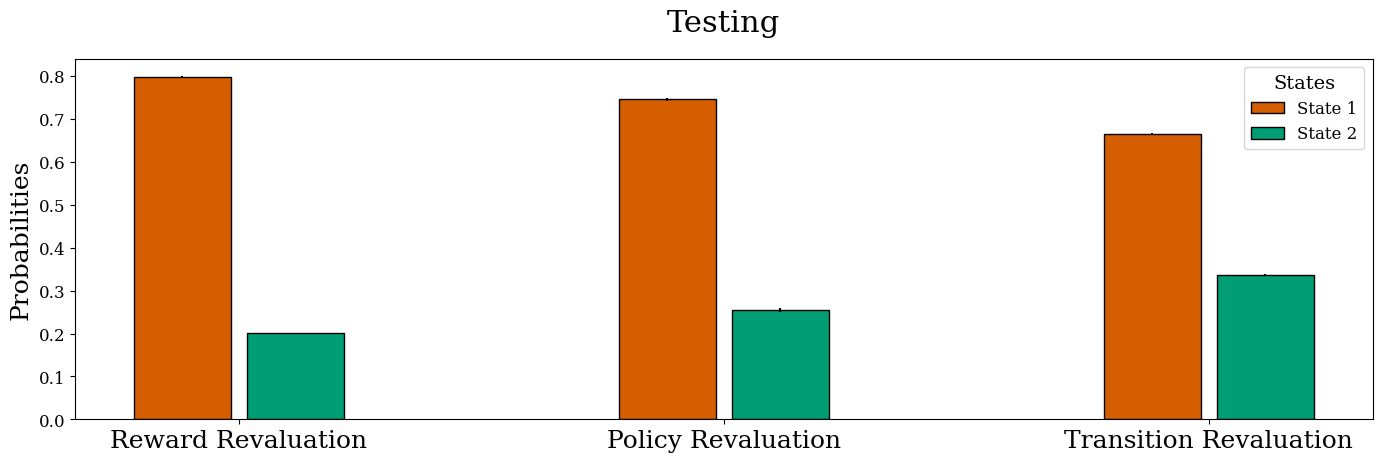

In [18]:
save_path = save_dir + "nhb_simulations_test.png"
# save_path = None

plot_nhb_decisions(
    probs_reward=mean_reward_test,
    probs_policy=mean_policy_test,
    probs_transition=mean_transition_test,
    colors=colors,
    leg_loc='upper right',
    save_path=save_path,
    title='Testing',
    std=[sem_reward_test, sem_policy_test, sem_transition_test]
)